## Data Preparation

### Getting data from yfinance

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import numpy as np
import os
import json

import pandas as pd
from sklearn.preprocessing import StandardScaler

from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, MACD
from ta.volatility import AverageTrueRange

import yfinance as yf
from torch.utils.tensorboard import SummaryWriter

config = {
    "yfinance": {
        "symbol": "AAPL",
        "symbols": [
            "AAPL", "MSFT", "GOOG", "AMZN",
            "META", "NVDA", "SPY", "XLK", 
            "TSLA", "CRM", "ADBE", "QCOM"
        ],
        "period": "10y",
        "interval": "1d",
    },
    "data": {
        "window_size": 90, 
        "train_split_size": 0.70,
        "val_split_size": 0.15,
        "test_split_size": 0.15,
    }, 
    "plots": {
        "xticks_interval": 45,
        "color_actual": "#ff8000",
        "color_train": "#58F6AF",
        "color_val": "#7CC2FF",
        "color_test": "#F98B8B",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#00529A",
        "color_pred_test": "#E00000",
    },
    "model": {
        "num_lstm_layers": 2,
        "lstm_size": 64, # hidden state dimensionality
        "dropout": 0.3,
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 128,
        "num_epoch": 100,
        "learning_rate": 5e-4,
        "weight_decay": 1e-2,
        "scheduler_step_size": 40,
    }
}

plt.style.use("dark_background")

In [3]:
data_list = []

for symbol in config["yfinance"]["symbols"]:
    ticker = yf.Ticker(symbol)
    df = ticker.history(start="2015-01-01", interval=config["yfinance"]["interval"], auto_adjust=True, actions=False)
    df = df.add_prefix(f"{symbol}_")
    data_list.append(df)

combined_df = pd.concat(data_list, axis=1).reset_index()
combined_df

,Date,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,...,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Volume
0,2015-01-02 00:00:00-05:00,24.718176,24.729272,23.821673,24.261049,212818400.0,39.847653,40.496692,39.745174,39.933052,...,72.699997,73.199997,71.889999,72.339996,2349200,55.093441,55.359629,54.531488,54.923374,6662700.0
1,2015-01-05 00:00:00-05:00,24.030263,24.110150,23.391173,23.577574,257142000.0,39.599995,39.907436,39.497516,39.565838,...,72.209999,72.430000,71.570000,71.980003,2403300,54.501922,55.086056,54.442767,54.664593,12042800.0
2,2015-01-06 00:00:00-05:00,23.641929,23.839426,23.218087,23.579796,263188400.0,39.608547,39.924526,38.891186,38.985126,...,71.949997,72.099998,69.879997,70.529999,2895400,54.612846,55.167404,53.784705,53.888222,11094000.0
3,2015-01-07 00:00:00-05:00,23.788385,24.010292,23.677432,23.910435,160423600.0,39.266934,39.676854,38.848476,39.480434,...,70.769997,71.290001,70.419998,71.110001,2378300,54.250520,55.063870,53.947359,54.516708,10030700.0
4,2015-01-08 00:00:00-05:00,24.238859,24.886826,24.121248,24.829130,237458000.0,39.924520,40.778520,39.898901,40.641880,...,71.400002,73.059998,71.309998,72.919998,2624200,54.938177,55.677587,54.819869,55.093452,10937200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,2025-08-19 00:00:00-04:00,231.279999,232.869995,229.350006,230.559998,39402600.0,514.154777,514.314488,507.715351,508.933350,...,359.220001,364.239990,358.119995,361.029999,2808000,159.070007,159.429993,156.050003,156.250000,6396500.0
2673,2025-08-20 00:00:00-04:00,229.979996,230.470001,225.770004,226.009995,42263900.0,509.033198,510.161348,503.612117,504.890015,...,361.679993,363.000000,353.200012,353.429993,3727900,156.389999,156.639999,153.460007,155.440002,7151700.0
2674,2025-08-21 00:00:00-04:00,226.270004,226.520004,223.779999,224.899994,30621200.0,503.690002,507.630005,502.720001,504.239990,...,349.910004,353.820007,347.000000,353.429993,2363200,154.820007,155.199997,153.050003,154.130005,4997300.0
2675,2025-08-22 00:00:00-04:00,226.169998,229.089996,225.410004,227.759995,42445300.0,504.250000,510.730011,502.410004,507.230011,...,355.799988,362.649994,354.000000,362.089996,3055900,154.830002,159.889999,154.559998,158.009995,7710400.0


In [4]:
data_dates = combined_df["Date"].tolist()

data_dates = [date.strftime("%Y-%m-%d") for date in data_dates]
num_data_points = len(combined_df)
display_date_range = f"from {data_dates[0]} to {data_dates[-1]}"

print("Number of data points:", num_data_points, display_date_range)

Number of data points: 2677 from 2015-01-02 to 2025-08-25


### Compute technical indicators

In [5]:
all_indicators = []

for symbol in config["yfinance"]["symbols"]:
    df_ind = pd.DataFrame(index=combined_df.index)
    close = combined_df[f"{symbol}_Close"]
    high = combined_df[f"{symbol}_High"]
    low = combined_df[f"{symbol}_Low"]
    volume = combined_df[f"{symbol}_Volume"]

    # Price-based indicators
    df_ind[f"{symbol}_Return"] = close.pct_change() # daily returns

    # Momentum indicators
    macd = MACD(close)
    df_ind[f"{symbol}_MACD_diff"] = macd.macd_diff()
    df_ind[f"{symbol}_RSI_14"] = RSIIndicator(close, window=14).rsi()

    # Volatility
    df_ind[f"{symbol}_ATR_14"] = AverageTrueRange(high, low, close, window=14).average_true_range()

    # Volume
    df_ind[f"{symbol}_Volume"] = volume

    all_indicators.append(df_ind)

# Concatenate all indicator columns at once
indicators_df = pd.concat(all_indicators, axis=1)
combined_df = pd.concat([combined_df, indicators_df], axis=1)

combined_df = combined_df.iloc[35:].reset_index(drop=True)
combined_df

C:\Users\zheng\AppData\Local\Temp\ipykernel_14388\3656706022.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_ind[f"{symbol}_Return"] = close.pct_change() # daily returns
C:\Users\zheng\AppData\Local\Temp\ipykernel_14388\3656706022.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_ind[f"{symbol}_Return"] = close.pct_change() # daily returns
C:\Users\zheng\AppData\Local\Temp\ipykernel_14388\3656706022.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling

,Date,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,...,ADBE_Return,ADBE_MACD_diff,ADBE_RSI_14,ADBE_ATR_14,ADBE_Volume,QCOM_Return,QCOM_MACD_diff,QCOM_RSI_14,QCOM_ATR_14,QCOM_Volume
0,2015-02-24 00:00:00-05:00,29.616692,29.763729,29.222366,29.445148,276912400.0,37.972428,38.101438,37.774607,37.920822,...,-0.005378,0.496518,67.904909,1.340718,1954300,0.006062,0.392744,54.737417,1.143997,10131900.0
1,2015-02-25 00:00:00-05:00,29.309247,29.318160,28.549558,28.692139,298846800.0,37.800427,37.920838,37.671414,37.834831,...,0.005021,0.420846,69.233108,1.314239,1256400,0.004344,0.374731,56.044018,1.126717,10578100.0
2,2015-02-26 00:00:00-05:00,28.692142,29.155530,28.206478,29.055279,365150000.0,37.834826,38.041243,37.748816,37.895031,...,0.011400,0.396672,72.073340,1.295365,1546000,0.004603,0.361933,57.451905,1.081095,9838700.0
3,2015-02-27 00:00:00-05:00,28.961709,29.088697,28.569613,28.618626,248059200.0,37.955244,38.015450,37.551007,37.714420,...,0.001773,0.357276,72.503342,1.300696,3115800,0.006944,0.360272,59.565331,1.076231,10297400.0
4,2015-03-02 00:00:00-05:00,28.794614,29.024080,28.582972,28.758968,192386800.0,37.559596,38.006837,37.456388,37.740215,...,0.008723,0.344690,74.580760,1.284218,1497700,0.007907,0.368319,61.902061,1.067885,8979300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2025-08-19 00:00:00-04:00,231.279999,232.869995,229.350006,230.559998,39402600.0,514.154777,514.314488,507.715351,508.933350,...,0.010609,2.739560,52.765231,8.129054,2808000,-0.016677,0.955383,53.924198,3.609905,6396500.0
2638,2025-08-20 00:00:00-04:00,229.979996,230.470001,225.770004,226.009995,42263900.0,509.033198,510.161348,503.612117,504.890015,...,-0.021051,2.611958,47.084187,8.248407,3727900,-0.005184,0.802782,52.251192,3.579197,7151700.0
2639,2025-08-21 00:00:00-04:00,226.270004,226.520004,223.779999,224.899994,30621200.0,503.690002,507.630005,502.720001,504.239990,...,0.000000,2.462491,47.084187,8.146378,2363200,-0.008428,0.585630,49.572481,3.494254,4997300.0
2640,2025-08-22 00:00:00-04:00,226.169998,229.089996,225.410004,227.759995,42445300.0,504.250000,510.730011,502.410004,507.230011,...,0.024503,2.854203,53.675402,8.223066,3055900,0.025173,0.669280,56.659566,3.656093,7710400.0


### Visualize

In [6]:
features = ["Return", "MACD_diff", "ATR_14", "RSI_14", "Volume"]
features_cols = []

for feature in features:
    for symbol in config["yfinance"]["symbols"]:
        features_cols.append(f"{symbol}_{feature}")

combined_df_features = combined_df[features_cols]
combined_df_features

,AAPL_Return,MSFT_Return,GOOG_Return,AMZN_Return,META_Return,NVDA_Return,SPY_Return,XLK_Return,TSLA_Return,CRM_Return,...,XLK_Volume,XLK_Volume,TSLA_Volume,TSLA_Volume,CRM_Volume,CRM_Volume,ADBE_Volume,ADBE_Volume,QCOM_Volume,QCOM_Volume
0,-0.006241,-0.001359,0.007858,-0.004077,-0.004947,0.010646,0.002841,0.003016,-0.015578,-0.010387,...,4655500.0,4655500.0,99054000.0,99054000.0,5481700.0,5481700.0,1954300,1954300,10131900.0,10131900.0
1,-0.025573,-0.002268,0.014513,0.017908,0.014149,-0.007620,-0.000850,-0.006244,-0.001715,0.015178,...,5867400.0,5867400.0,58642500.0,58642500.0,7634000.0,7634000.0,1256400,1256400,10578100.0,10578100.0
2,0.012656,0.001591,0.021347,-0.001479,0.010684,0.002710,-0.001181,0.006283,0.016834,0.117226,...,7559400.0,7559400.0,97093500.0,97093500.0,20370800.0,20370800.0,1546000,1546000,9838700.0,9838700.0
3,-0.015028,-0.004766,0.005257,-0.012058,-0.017908,-0.006307,-0.003406,-0.003469,-0.018582,-0.012244,...,6056000.0,6056000.0,58231500.0,58231500.0,8289500.0,8289500.0,3115800,3115800,10297400.0,10297400.0
4,0.004904,0.000684,0.023173,0.014468,0.009877,0.024479,0.006314,0.007890,-0.029556,-0.013260,...,6844500.0,6844500.0,118831500.0,118831500.0,8124800.0,8124800.0,1497700,1497700,8979300.0,8979300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,-0.001429,-0.014175,-0.008811,-0.015033,-0.020707,-0.034998,-0.005425,-0.017463,-0.017454,0.008321,...,8683500.0,8683500.0,75956000.0,75956000.0,8642200.0,8642200.0,2808000,2808000,6396500.0,6396500.0
2638,-0.019735,-0.007945,-0.011359,-0.018420,-0.005003,-0.001366,-0.002657,-0.006765,-0.016428,0.001829,...,11532100.0,11532100.0,77481800.0,77481800.0,8195100.0,8195100.0,3727900,3727900,7151700.0,7151700.0
2639,-0.004911,-0.001287,0.002148,-0.008311,-0.011528,-0.002395,-0.004012,-0.003617,-0.011701,-0.002516,...,7574300.0,7574300.0,55744400.0,55744400.0,5646800.0,5646800.0,2363200,2363200,4997300.0,4997300.0
2640,0.012717,0.005930,0.030406,0.031043,0.021229,0.017202,0.015357,0.013557,0.062166,0.010007,...,6877100.0,6877100.0,93588800.0,93588800.0,6690300.0,6690300.0,3055900,3055900,7710400.0,7710400.0


ValueError: x and y must have same first dimension, but have shapes (2677,) and (2642,)

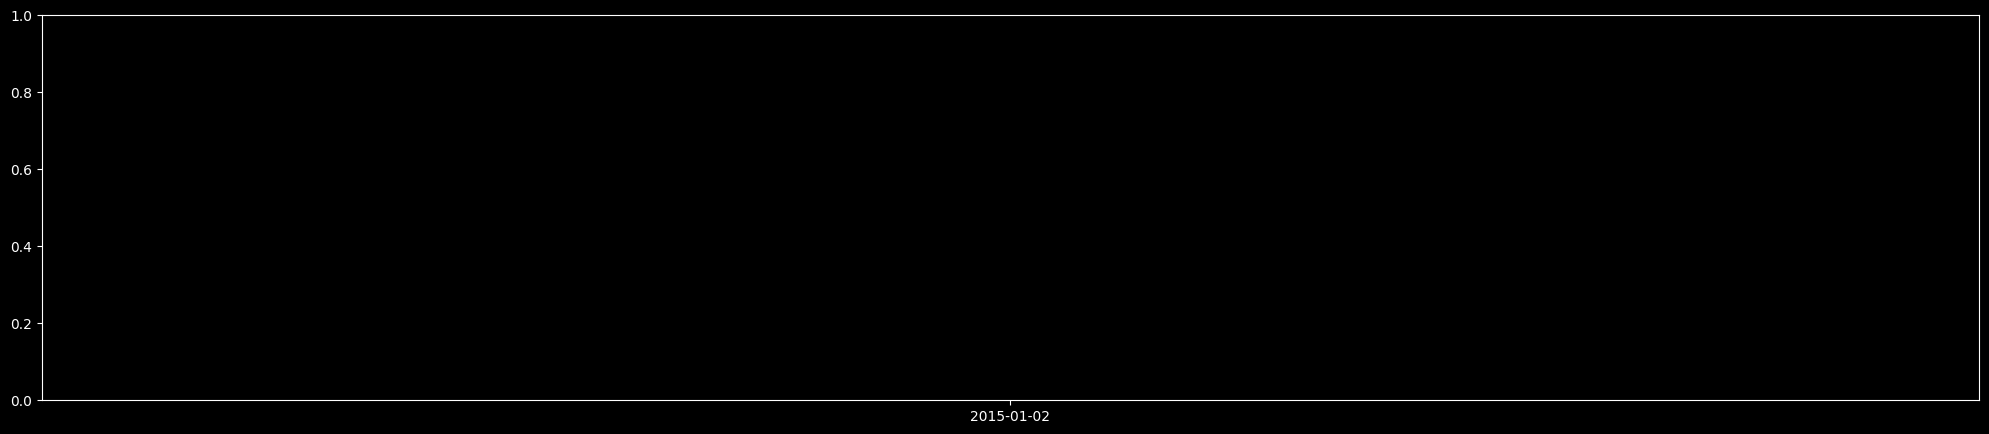

In [151]:

def plot_feature(df, feature):
    fig = plt.figure(figsize=(25, 5), dpi=100)
    fig.patch.set_facecolor(color="black")

    plt.plot(data_dates, df[feature].values, color=config["plots"]["color_actual"])

    xticks_labels = []
    xticks_interval = config["plots"]["xticks_interval"]

    for i in range(num_data_points):
        # Always include the last data point
        if i == num_data_points - 1:
            xticks_labels.append(data_dates[i])
        # Include every xticks_interval-th point, but avoid ticks too close to the end
        elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
            xticks_labels.append(data_dates[i])
        else:
            xticks_labels.append(None)

    xticks_indices = np.arange(0, len(xticks_labels))
    plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

    plt.title(f"{feature} for {config["yfinance"]["symbol"]}, {display_date_range}")
    plt.grid(axis="y", linestyle="--")

plot_feature(combined_df, f"{config["yfinance"]["symbol"]}_Close")
plot_feature(combined_df, f"{config["yfinance"]["symbol"]}_RSI_14")

### Normalization

In [7]:
combined_df_features = combined_df_features.copy()

for col in features_cols:
    if col.endswith("RSI_14"):
        combined_df_features[col] = (combined_df_features[col] / 100.0)
    else:
        combined_df_features[col] = (combined_df_features[col] - combined_df_features[col].mean()) / combined_df_features[col].std()

combined_df_features

,AAPL_Return,MSFT_Return,GOOG_Return,AMZN_Return,META_Return,NVDA_Return,SPY_Return,XLK_Return,TSLA_Return,CRM_Return,...,XLK_Volume,XLK_Volume,TSLA_Volume,TSLA_Volume,CRM_Volume,CRM_Volume,ADBE_Volume,ADBE_Volume,QCOM_Volume,QCOM_Volume
0,-0.392214,-0.145986,0.381073,-0.253039,-0.255062,0.256784,0.201464,0.143905,-0.475506,-0.508410,...,-0.843230,-0.843230,-0.183045,-0.183045,-0.148584,-0.148584,-0.606133,-0.606133,-0.045599,-0.045599
1,-1.448251,-0.199345,0.747796,0.810158,0.544453,-0.331989,-0.123894,-0.470282,-0.097995,0.657093,...,-0.646981,-0.646981,-0.739413,-0.739413,0.365805,0.365805,-1.008342,-1.008342,0.018094,0.018094
2,0.640027,0.027311,1.124450,-0.127388,0.399366,0.000998,-0.153130,0.360654,0.407086,5.309443,...,-0.372986,-0.372986,-0.210036,-0.210036,3.409833,3.409833,-0.841442,-0.841442,-0.087452,-0.087452
3,-0.872239,-0.346098,0.237685,-0.638976,-0.797742,-0.289649,-0.349245,-0.286211,-0.557298,-0.593077,...,-0.616440,-0.616440,-0.745071,-0.745071,0.522466,0.522466,0.063254,0.063254,-0.021975,-0.021975
4,0.216549,-0.025974,1.225114,0.643766,0.365591,0.702680,0.507628,0.467237,-0.856137,-0.639412,...,-0.488754,-0.488754,0.089243,0.089243,0.483103,0.483103,-0.869278,-0.869278,-0.210126,-0.210126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,-0.129396,-0.898767,-0.537610,-0.782834,-0.914927,-1.214485,-0.527249,-1.214432,-0.526591,0.344458,...,-0.190955,-0.190955,-0.501048,-0.501048,0.606759,0.606759,-0.114135,-0.114135,-0.578807,-0.578807
2638,-1.129314,-0.532805,-0.678016,-0.946630,-0.257439,-0.130409,-0.283218,-0.504857,-0.498651,0.048515,...,0.270334,0.270334,-0.480041,-0.480041,0.499905,0.499905,0.416016,0.416016,-0.471007,-0.471007
2639,-0.319600,-0.141770,0.066355,-0.457749,-0.530627,-0.163547,-0.402655,-0.296056,-0.369929,-0.149571,...,-0.370573,-0.370573,-0.779312,-0.779312,-0.109126,-0.109126,-0.370479,-0.370479,-0.778536,-0.778536
2640,0.643323,0.282154,1.623702,1.445319,0.840857,0.468125,1.304863,0.843086,1.641515,0.421332,...,-0.483475,-0.483475,-0.258287,-0.258287,0.140265,0.140265,0.028733,0.028733,-0.391255,-0.391255


ValueError: x and y must have same first dimension, but have shapes (2677,) and (2642,)

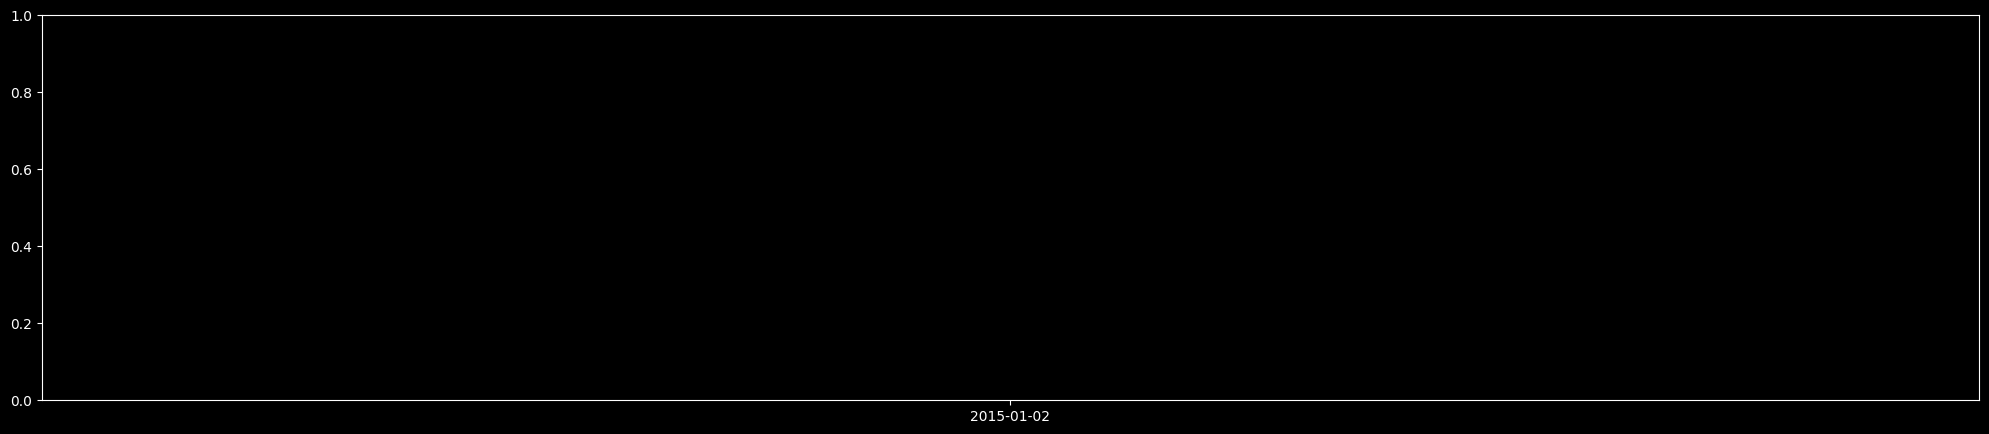

In [153]:
plot_feature(combined_df_features, f"{config["yfinance"]["symbol"]}_Return")
plot_feature(combined_df_features, f"{config["yfinance"]["symbol"]}_RSI_14")

### Sliding windows

In [8]:
window_size = config["data"]["window_size"]

target_col = "AAPL_Close"
n_row = combined_df_features.shape[0] - window_size

X = np.array([
    combined_df_features.iloc[i:i+window_size].values 
    for i in range(n_row)
])

raw_prices = combined_df[target_col].values
log_returns = np.log(raw_prices[1:] / raw_prices[:-1])   # type: ignore

y = np.array([
    log_returns[i + window_size - 1] # return[t] = log(p[t+1]/p[t])
    for i in range(n_row)
])


X.shape, y.shape

((2552, 90, 72), (2552,))

### Train/Val/Test split

In [9]:
train_end = int(config["data"]["train_split_size"] * len(y))
val_end   = int((config["data"]["train_split_size"] + config["data"]["val_split_size"]) * len(y))

X_train_full, y_train_full = X[:train_end], y[:train_end]
X_val_full,   y_val_full   = X[train_end:val_end], y[train_end:val_end]

X_trainval, y_trainval = X[:val_end], y[:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print(f"X_trainval: {X_trainval.shape}, y_trainval: {y_trainval.shape}\n")

print(f"X_train_full: {X_train_full.shape}, y_train_full: {y_train_full.shape}")
print(f"X_val_full: {X_val_full.shape}, y_val_full: {y_val_full.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_trainval: (2169, 90, 72), y_trainval: (2169,)

X_train_full: (1786, 90, 72), y_train_full: (1786,)
X_val_full: (383, 90, 72), y_val_full: (383,)
X_test: (383, 90, 72), y_test: (383,)


In [10]:


window_size = config["data"]["window_size"]

to_plot_data_y_train, to_plot_data_y_val, to_plot_data_y_test = np.array([None] * num_data_points), np.array([None] * num_data_points), np.array([None] * num_data_points)


to_plot_data_y_train[window_size : window_size + train_end] = combined_df.iloc[window_size : window_size + train_end, 1].values
to_plot_data_y_val[window_size + train_end : window_size + val_end] = combined_df.iloc[window_size + train_end: window_size + val_end, 1].values
to_plot_data_y_test[window_size + val_end : ] = combined_df.iloc[window_size + val_end : , 1].values


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])
plt.plot(data_dates, to_plot_data_y_test, label = "Test", color=config["plots"]["color_test"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]
for i in range(num_data_points):
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["yfinance"]["symbol"]}, {display_date_range} - Train/Val/Test split")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)

ValueError: could not broadcast input array from shape (383,) into shape (418,)

### Datasets and DataLoaders

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    

dataset_train = TimeSeriesDataset(X_train_full, y_train_full)
dataset_val = TimeSeriesDataset(X_val_full, y_val_full)
dataset_test = TimeSeriesDataset(X_test, y_test)

print("Train data shape:", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape:", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape:", dataset_test.x.shape, dataset_test.y.shape)


Train data shape: torch.Size([1786, 90, 72]) torch.Size([1786])
Validation data shape: torch.Size([383, 90, 72]) torch.Size([383])
Test data shape: torch.Size([383, 90, 72]) torch.Size([383])


In [12]:
train_dataloader_full = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader_full = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=False)

## LSTM Model

PyTorch condenses the math:

$$f_t = \sigma(W_{if} x_t + W_{hf} h_{t-1} + b_f) \\
i_t = \sigma(W_{ii} x_t + W_{hi} h_{t-1} + b_i) \\
\tilde{C}_t = \tanh(W_{iC} x_t + W_{hC} h_{t-1} + b_C) \\
o_t = \sigma(W_{io} x_t + W_{ho} h_{t-1} + b_o)$$

All the $W_{i*}$ (input -> gate) matrices are stacked together into weight_ih

All the $W_{h*}$ (hidden -> gate) are stacked together into weight_hh

$$\begin{bmatrix}
f_t \\
i_t \\
\tilde{C}_t \\
o_t
\end{bmatrix}
=
\begin{bmatrix}
\sigma \\
\sigma \\
\tanh \\
\sigma
\end{bmatrix}
\Big(
W_{ih} x_t + W_{hh} h_{t-1} + b_{ih} + b_{hh}
\Big)$$


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, attn_heads = 2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size)
        self.relu = nn.ReLU()
        # batch_first = True makes input/output (batch_size, seq_len, feature_num) instead of (seq_len, batch_size, feature_num) 
        self.lstm = nn.LSTM(input_size=hidden_layer_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=0.1)
        
        self.attention = nn.MultiheadAttention(embed_dim=hidden_layer_size, 
                                               num_heads=attn_heads, 
                                               dropout=0.1,
                                               batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                 nn.init.zeros_(param)
            elif "weight_ih" in name:
                 nn.init.kaiming_normal_(param) # normal distribution scaled to preserve variance across layers
            elif "weight_hh" in name:
                 nn.init.orthogonal_(param) # preserves the gradient norm so it doesn't vanish/explode


    def forward(self, x):

        x = self.linear_1(x) # (batch, seq_len, num_features) -> (batch, seq_len, hidden_layer_size) 
        x = self.relu(x)

        # output has shape (batch, seq_len, hidden_layer_size). Hidden state from last LSTM layer, at every time step
        # h_n has shape (num_layers, batch, hidden_layer_size). Final hidden state for each layer, at the last time step
        # c_n has the same shape as h_n. Final cell state for each layer, at the last time step.
        lstm_out, (h_n, c_n) = self.lstm(x)

        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        x = attn_out.mean(dim=1)  # (batch, hidden_layer_size)

        x = self.dropout(x)

        x = self.linear_2(x) # (batch, output_size)
        return x

## Model Training

In [14]:
writer = SummaryWriter(log_dir="runs/stock_lstm_final")

torch.manual_seed(1166543265)

device = config["training"]["device"]

model = LSTMModel(input_size=X.shape[-1], 
                  hidden_layer_size=config["model"]["lstm_size"], 
                  num_layers=config["model"]["num_lstm_layers"], 
                  dropout=config["model"]["dropout"])

model = model.to(device)


criterion = nn.HuberLoss(delta=1.0)

optimizer = optim.AdamW(params = model.parameters(),
                        lr=config["training"]["learning_rate"],
                        betas=(0.9, 0.98),
                        eps=1e-9,
                        weight_decay=config["training"]["weight_decay"])


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.5, 
    patience=2,
    min_lr=1e-6
)


train_window = 1000
val_window = 150
step_size = 200
batch_size = config["training"]["batch_size"]

start = 0
epoch_count = 0

while start + train_window + val_window <= len(X_trainval):
    X_train, y_train = X_trainval[start:start+train_window], y_trainval[start:start+train_window]
    X_val, y_val = X_trainval[start + train_window : start + train_window + val_window], \
                   y_trainval[start + train_window : start + train_window + val_window]

    train_dataloader = DataLoader(
        TimeSeriesDataset(X_train, y_train),
        batch_size=batch_size, shuffle=True
    )

    val_dataloader = DataLoader(
        TimeSeriesDataset(X_val, y_val),
        batch_size=batch_size, shuffle=False
    )


    for _ in range(3):
        model.train()
        
        train_loss = 0.0

        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)

            train_pred = model(X)
            train_pred = train_pred.squeeze(-1)

            loss = criterion(train_pred, y)

            optimizer.zero_grad()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
            optimizer.step()

            train_loss += loss.detach().item()

        train_loss = train_loss / len(train_dataloader)

        epoch_count += 1
        writer.add_scalar("Loss/Train", train_loss, epoch_count)

        current_lr = optimizer.param_groups[0]["lr"]

        print(f"Epoch {epoch_count:03d} | train loss: {train_loss:.6f} | lr: {current_lr:.6f}")


    model.eval()

    val_loss = 0.0
    total_weighted_correct = 0.0
    total_weights = 0.0

    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            val_pred = model(X)
            val_pred = val_pred.squeeze(-1)

            val_loss += criterion(val_pred, y).item()

            true_dir = torch.sign(y)
            pred_dir = torch.sign(val_pred)

            weights = torch.clamp(torch.abs(y), min=1e-5)

            total_weighted_correct += (true_dir == pred_dir).float().dot(weights).item()
            total_weights += weights.sum().item()


    val_loss = val_loss / len(val_dataloader)

    scheduler.step(val_loss)

    weighted_accuracy = total_weighted_correct / total_weights

    writer.add_scalar("Loss/Validation", val_loss, epoch_count)
    writer.add_scalar("Metrics/WeightedAcc", weighted_accuracy, epoch_count)


    writer.flush()


    print(f"Train[{start}:{start+train_window}] -> Val[{start+train_window}:{start+train_window+val_window}] "
          f"| Val Loss: {val_loss:.6f} | Acc: {100*weighted_accuracy:.2f}%")
    
    start += step_size


Epoch 001 | train loss: 0.000313 | lr: 0.000500
Epoch 002 | train loss: 0.000182 | lr: 0.000500
Epoch 003 | train loss: 0.000150 | lr: 0.000500
Train[0:1000] -> Val[1000:1150] | Val Loss: 0.000115 | Acc: 36.43%
Epoch 004 | train loss: 0.000180 | lr: 0.000500
Epoch 005 | train loss: 0.000171 | lr: 0.000500
Epoch 006 | train loss: 0.000169 | lr: 0.000500
Train[200:1200] -> Val[1200:1350] | Val Loss: 0.000340 | Acc: 46.47%
Epoch 007 | train loss: 0.000206 | lr: 0.000500
Epoch 008 | train loss: 0.000203 | lr: 0.000500
Epoch 009 | train loss: 0.000206 | lr: 0.000500
Train[400:1400] -> Val[1400:1550] | Val Loss: 0.000098 | Acc: 51.79%
Epoch 010 | train loss: 0.000221 | lr: 0.000500
Epoch 011 | train loss: 0.000217 | lr: 0.000500
Epoch 012 | train loss: 0.000215 | lr: 0.000500
Train[600:1600] -> Val[1600:1750] | Val Loss: 0.000318 | Acc: 47.33%
Epoch 013 | train loss: 0.000240 | lr: 0.000500
Epoch 014 | train loss: 0.000243 | lr: 0.000500
Epoch 015 | train loss: 0.000239 | lr: 0.000500
Train[

## Model Evaluation

### Accuracy and Sharpe

In [15]:
def evaluate_metrics(model, dataloader, split, device):
    loss = 0.0
    total_weighted_correct = 0.0
    total_weights = 0.0
    strategy_returns_list = []
    

    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            pred = pred.squeeze(-1)

            loss += criterion(pred, y).item()

            true_dir = torch.sign(y)
            pred_dir = torch.sign(pred)

            weights = torch.abs(y)

            strategy_returns = (pred_dir * y).numpy()
            strategy_returns_list.append(strategy_returns)


            total_weighted_correct += (true_dir == pred_dir).float().dot(weights).item()
            total_weights += weights.sum().item()

    loss = loss / len(dataloader)
    weighted_accuracy = total_weighted_correct / total_weights
    strategy_returns_list = np.concatenate(strategy_returns_list)
    sharpe_ratio = (np.mean(strategy_returns_list) * np.sqrt(252)) / np.std(strategy_returns_list)

    print(f"{split} loss: {loss:.6f} | {split} weighted accuracy: {weighted_accuracy*100:.2f}% | Sharpe ratio: {sharpe_ratio:.4f}")


In [16]:
# model.load_state_dict(torch.load("best_model_acc.pt"))
# torch.save(model.state_dict(), "best_model_acc.pt")

evaluate_metrics(model, train_dataloader_full, "train", device)
evaluate_metrics(model, val_dataloader_full, "val", device)
evaluate_metrics(model, test_dataloader, "test", device)

train loss: 0.000177 | train weighted accuracy: 55.90% | Sharpe ratio: 1.2993
val loss: 0.000133 | val weighted accuracy: 57.36% | Sharpe ratio: 1.7114
test loss: nan | test weighted accuracy: nan% | Sharpe ratio: nan


### Get Predictions

In [17]:
train_preds_list = []
val_preds_list = []

train_pred_dataloader = DataLoader(dataset_train, batch_size=1, shuffle=False)
val_pred_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False)

with torch.inference_mode():
    prev_price = raw_prices[0]

    for i, (X, y) in enumerate(train_pred_dataloader):
        X, y = X.to(device), y.to(device)

        log_return = model(X).squeeze(-1).item()

        true_anchor = raw_prices[i + window_size - 1]
        pred_price = true_anchor * np.exp(log_return)

        train_preds_list.append(pred_price)

    train_preds = np.array(train_preds_list)


    all_val_log_returns = []
    for i, (X, y) in enumerate(val_pred_dataloader):
        
        X, y = X.to(device), y.to(device)

        log_return = model(X).squeeze(-1).item()

        true_anchor = raw_prices[i + window_size + train_end - 1]
        pred_price = true_anchor * np.exp(log_return)

        val_preds_list.append(pred_price)

    val_preds = np.array(val_preds_list)

### Plot Predictions

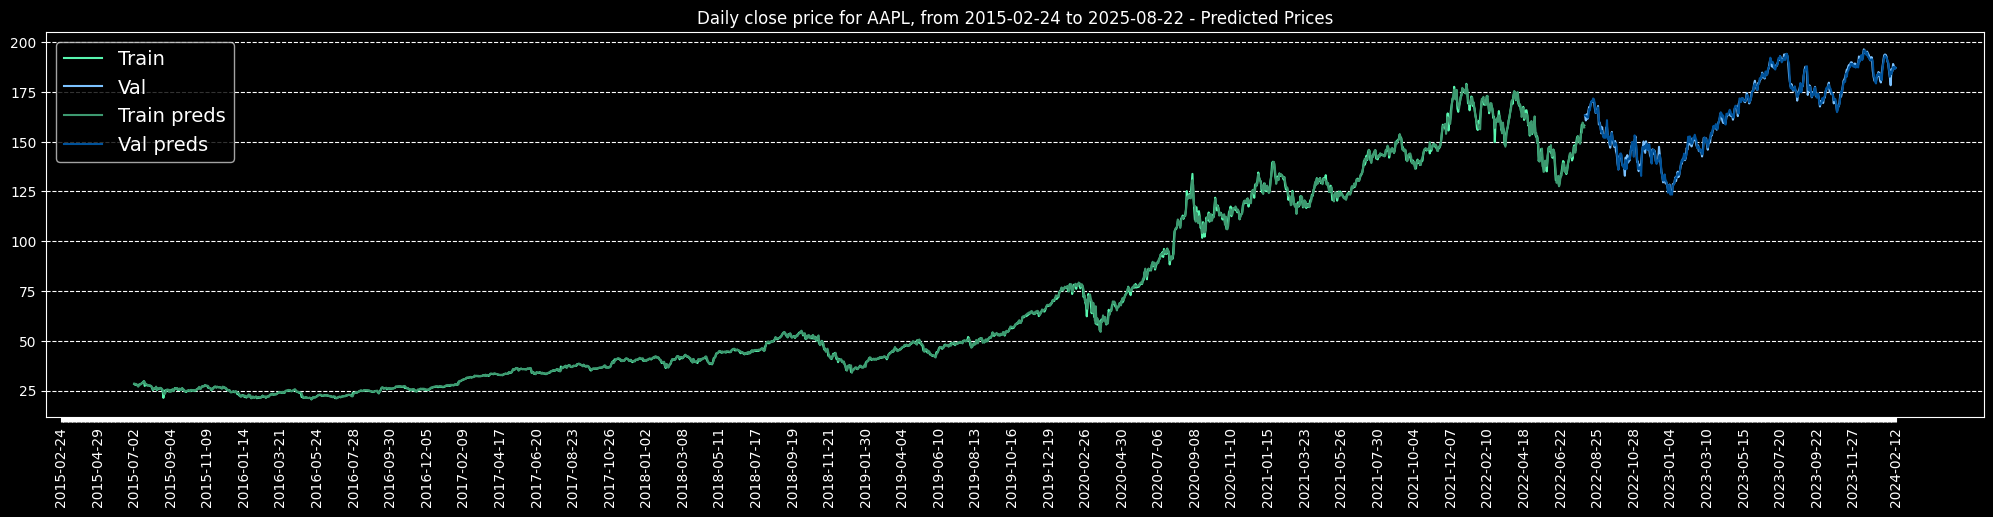

In [ ]:
window_size = config["data"]["window_size"]


to_plot_y_train_preds = np.array([None] * num_data_points)
to_plot_y_val_preds = np.array([None] * num_data_points)

to_plot_y_train_preds[window_size : window_size + train_end] = train_preds
to_plot_y_val_preds[window_size + train_end : window_size + val_end] = val_preds


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])

plt.plot(data_dates, to_plot_y_train_preds, label = "Train preds", color=config["plots"]["color_pred_train"])
plt.plot(data_dates, to_plot_y_val_preds, label = "Val preds", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]

num_pred_data_points = num_data_points - len(y_test)

for i in range(num_pred_data_points):
    if i == num_pred_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_pred_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["yfinance"]["symbol"]}, {display_date_range} - Predicted Prices")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Zoom in on Val Preds

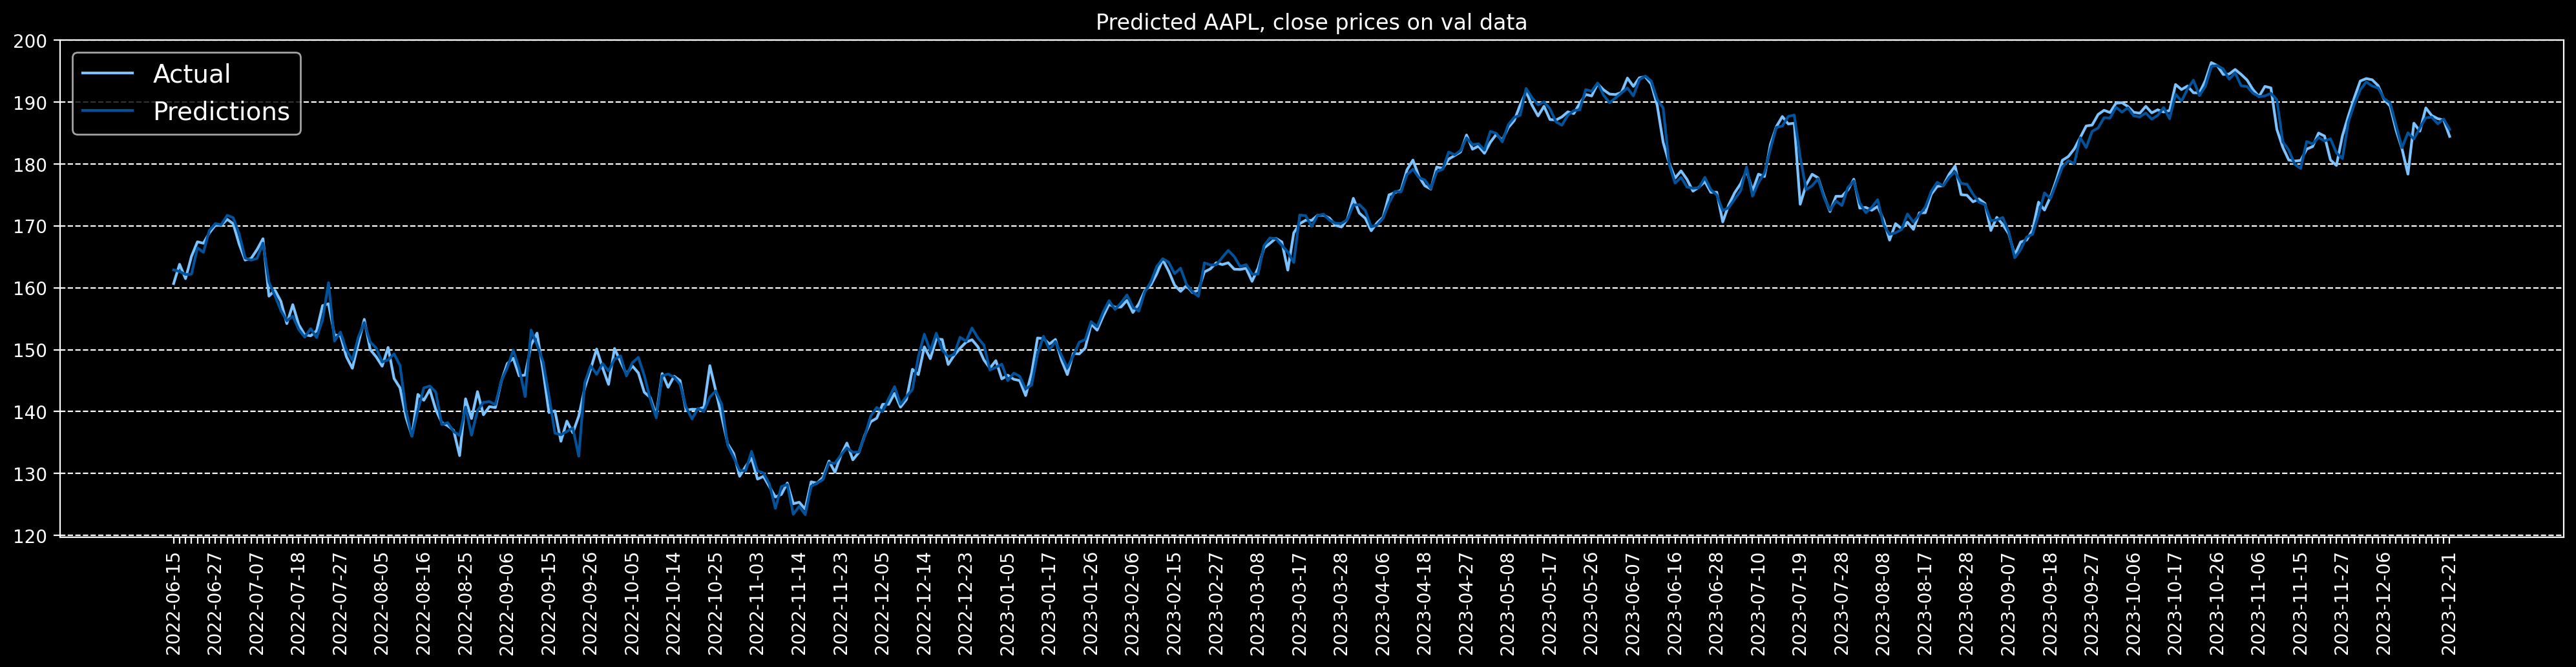

In [18]:
y_val_only = [p for p in to_plot_data_y_val if p]

data_dates_val = data_dates[window_size + train_end : window_size + val_end]

fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_val, y_val_only, label = "Actual", color=config["plots"]["color_val"])
plt.plot(data_dates_val, val_preds, label = "Predictions", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_val_data_points = len(data_dates_val)

for i in range(num_val_data_points):
    if i == num_val_data_points - 1:
        xticks_labels.append(data_dates_val[i])
    elif i % (xticks_interval) == 0 and (num_val_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_val[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["yfinance"]["symbol"]}, close prices on val data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Predictions on Test Data

In [19]:
test_preds_list = []

test_pred_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

with torch.inference_mode():
    prev_price = raw_prices[0]

    for i, (X, y) in enumerate(test_pred_dataloader):
        X, y = X.to(device), y.to(device)

        log_return = model(X).squeeze(-1).item()

        true_anchor = raw_prices[i + window_size + val_end - 1]
        pred_price = true_anchor * np.exp(log_return)

        test_preds_list.append(pred_price)

    test_preds = np.array(test_preds_list)


ValueError: x and y must have same first dimension, but have shapes (418,) and (0,)

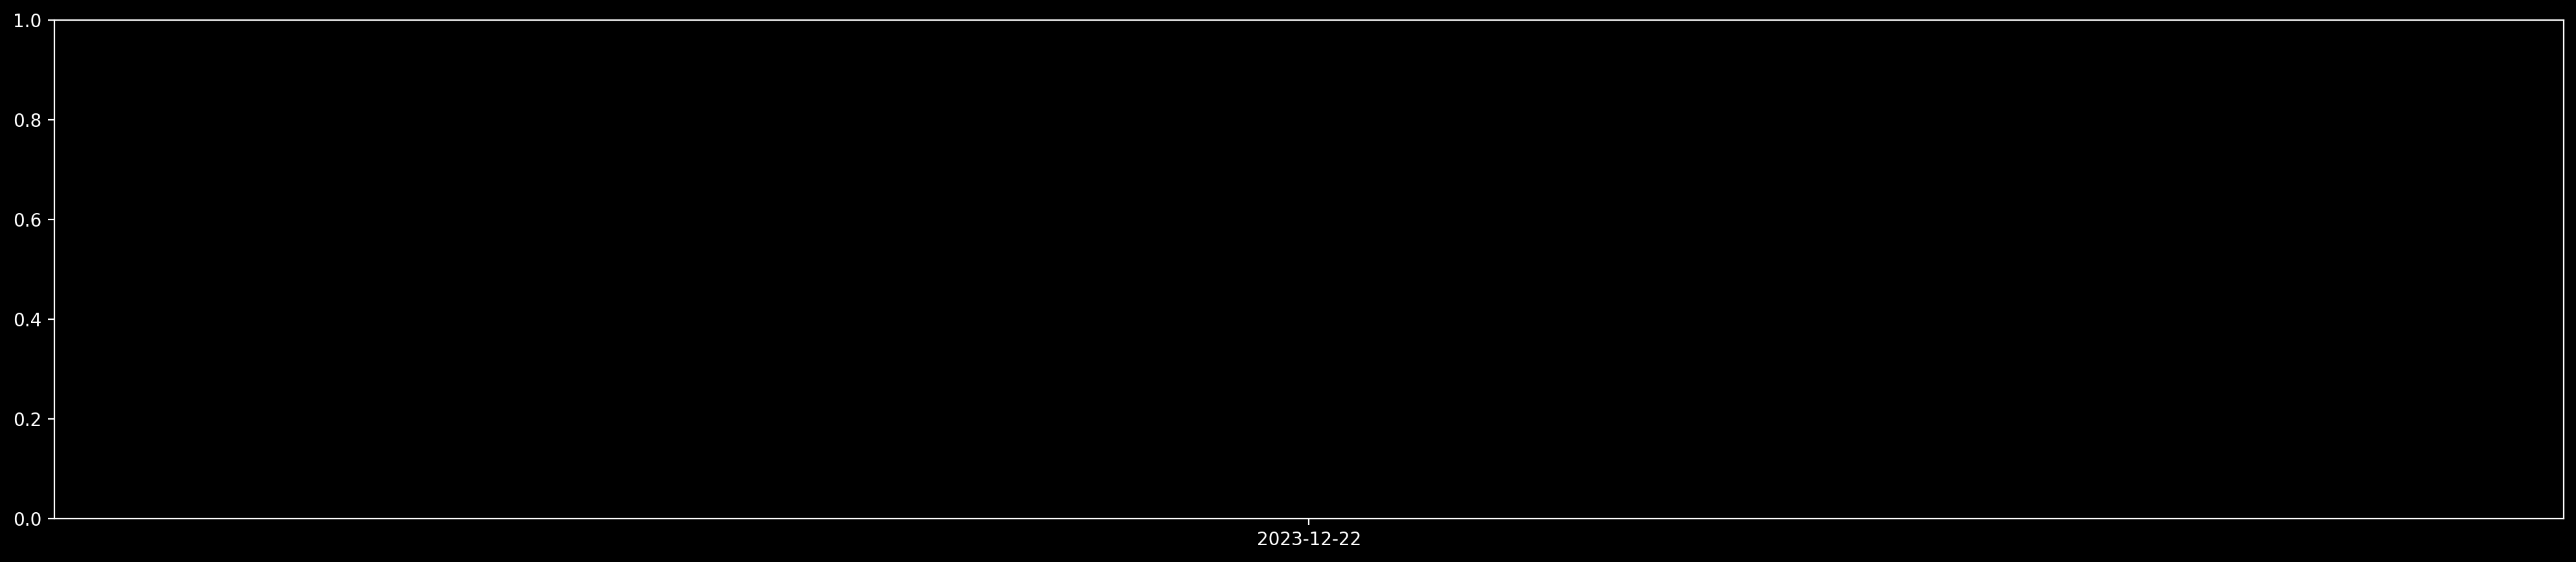

In [20]:
y_test_only = [p for p in to_plot_data_y_test if p]
data_dates_test = data_dates[window_size + val_end:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test, y_test_only, label = "Actual", color=config["plots"]["color_test"])
plt.plot(data_dates_test, test_preds, label = "Prediction", color=config["plots"]["color_pred_test"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_test_data_points = len(data_dates_test)

for i in range(num_test_data_points):
    if i == num_test_data_points - 1:
        xticks_labels.append(data_dates_test[i])
    elif i % (xticks_interval) == 0 and (num_test_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_test[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["yfinance"]["symbol"]}, close prices on test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)

In [21]:
y_test_tensor = torch.tensor(y_test_only)
test_preds_tensor = torch.tensor(test_preds)

true_dir = torch.sign(y_test_tensor[1:] - y_test_tensor[:-1])
pred_dir = torch.sign(test_preds_tensor[1:] - test_preds_tensor[:-1])

weights = torch.abs(y_test_tensor[1:] - y_test_tensor[:-1])

weighted_correct = (true_dir == pred_dir).float() * weights
weighted_accuracy = weighted_correct.sum() / weights.sum()

print(f"Weighted Directional Accuracy: {100*weighted_accuracy:.2f}%")

RuntimeError: The size of tensor a (0) must match the size of tensor b (382) at non-singleton dimension 0

#### Zoom in

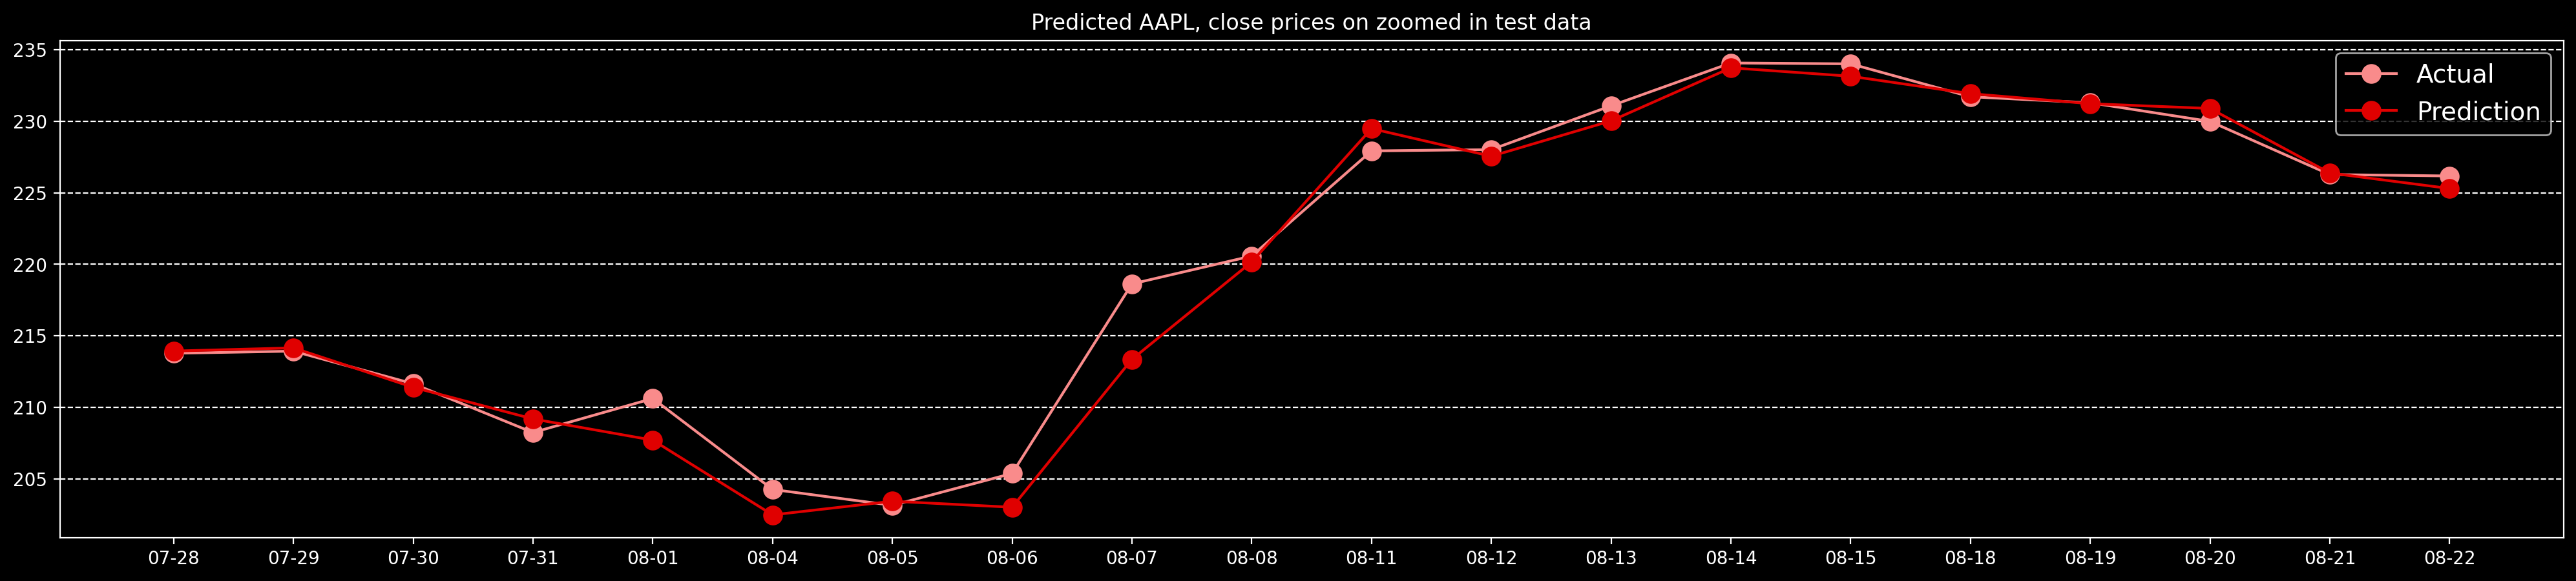

In [ ]:
num_days = 20

y_test_zoomed = y_test_only[-num_days:]
y_test_preds_zoomed = test_preds[-num_days:]

data_dates_test_zoomed = [date[5:] for date in data_dates[-num_days:]]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test_zoomed, y_test_zoomed, label = "Actual", color=config["plots"]["color_test"], marker="o", markersize=10)
plt.plot(data_dates_test_zoomed, y_test_preds_zoomed, label = "Prediction", color=config["plots"]["color_pred_test"], marker="o", markersize=10)


plt.title(f"Predicted {config["yfinance"]["symbol"]}, close prices on zoomed in test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)